<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Очистка-и-лемматизация-текста" data-toc-modified-id="Очистка-и-лемматизация-текста-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Очистка и лемматизация текста</a></span></li><li><span><a href="#Разделение-исходных-данных-на-выборки" data-toc-modified-id="Разделение-исходных-данных-на-выборки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Разделение исходных данных на выборки</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверка-качества-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-качества-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка качества модели на тестовой выборке</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Анализ тональности англоязычного текста

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель проекта** – построить модель, классифицирующую комментарии на позитивные и негативные, со значением метрики качества F1 не меньше 0.75.

**Задачи:** 

1. Загрузить и подготовить данные.

2. Обучить разные модели.
3. Сделать выводы.

***Описание данных***

* `text` – текст комментария, 

* `toxic` – целевой признак.

## Подготовка данных

In [1]:
# импортирование необходимых библиотек
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import warnings

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [2]:
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [3]:
# форматы чисел для вывода
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Изучение данных

In [4]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('E:/ЯП/Курс_спец_Data_Science/13_ML_для_текстов/toxic_comments.csv', index_col=0)

In [5]:
data.reset_index(drop=True, inplace=True)

In [6]:
# вывод первых 5 строк датафрейма
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
# общая информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
# количество явных дубликатов
data.duplicated().sum()

0

In [9]:
# уникальные значения в столбце в порядке убывания частоты их упоминаний
data.toxic.value_counts(normalize=True).to_frame()

,toxic
0,0.90
1,0.10


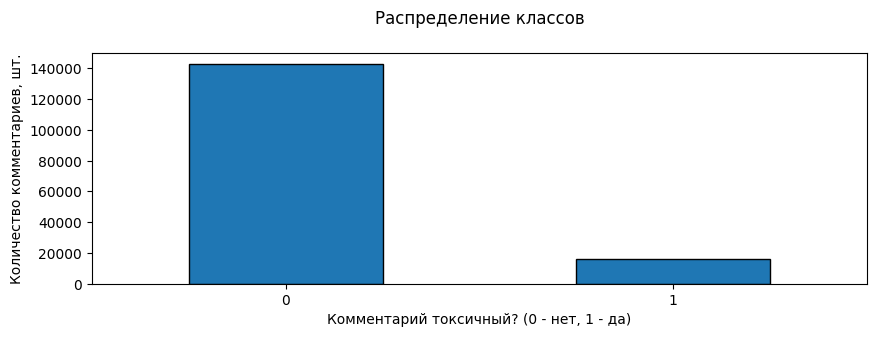

In [10]:
data.toxic.value_counts().plot(kind='bar', figsize=(10,3), rot=0, legend=False, fontsize=10, ec='black')
plt.title('Распределение классов\n')
plt.xlabel('Комментарий токсичный? (0 - нет, 1 - да)')
plt.ylabel('Количество комментариев, шт.');

Наблюдается дисбаланс классов в целевом признаке.

### Очистка и лемматизация текста

In [11]:
def clear_text(text):
    """
    Функция получает на вход строку. 
    Возвращает эту же строку, очищенную от всех символов кроме 
    латинских и пробелов, в нижнем регистре.

    """
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return (' '.join(text.split())).lower()

In [12]:
# очистка текста от лишних символов
data['clear_text'] = data['text'].apply(clear_text)

In [13]:
# check
data['clear_text'].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: clear_text, dtype: object

Имеется 11 комментариев с пустой строкой, удалим эти записи.

In [14]:
data[data['clear_text']=='']

,text,toxic,clear_text
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,
6289,193.61.111.53 15:00,0,
10193,"64.86.141.133""",0,
17280,~ \n\n68.193.147.157,0,
38743,"88.104.31.21""",0,
52336,"14:53,",0,
53679,92.24.199.233|92.24.199.233]],0,
61644,"""\n\n 199.209.144.211 """,0,
82541,"""\n '''''' 2010/2013 """,0,
119018,"""""""",1,


In [15]:
len(data[data['clear_text']==''])

11

In [16]:
# удаление записей с пустыми комментариями
data = data.query('clear_text != ""').reset_index(drop=True)
data.shape[0]

159281

In [17]:
def get_wordnet_pos(word):
    """
    Функция получает на вход слово. 
    Возвращает маркер части речи (POS-тег (part-of-speech)) этого слова.

    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
def lemmatize_text(text):
    """
    Функция получает на вход предложение. 
    Возвращает лемматизированное предложение.

    """
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)        
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])

In [19]:
# %%time
# # лемматизация текста
# data['lemm_text'] = data['clear_text'].apply(lemmatize_text)

Лемматизация текста занимает 42 минуты.

In [20]:
# сохранение лемматизированного корпуса
# data['lemm_text'].to_csv('lemm_corpus.csv', index=False)

In [21]:
# считывание лемматизированного корпуса
data['lemm_text'] = pd.read_csv('C:/Users/kek/lemm_corpus.csv')['lemm_text']

In [22]:
# check
data['lemm_text'].head()

0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: lemm_text, dtype: object

### Разделение исходных данных на выборки

In [23]:
# целевой признак
y = data['toxic']
# признаки
features = data['lemm_text']

В дальнейшем подбор гиперпараметров планируется выполнять автоматически с помощью `RandomizedSearchCV` (поиск по сетке, контроль качества осуществляется по технике кросс-валидации). Поэтому разобьем данные на 2 части - обучающую и тестовую выборки в соотношении 3:1.

Пропорцию классов при разделении будем задавать в соответствии с распределением по классам в целевом признаке `y`.

In [24]:
# выделение обучающей выборки (75 %) и тестовой (25 %)
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=12345, 
                                                    stratify=y)

In [25]:
# check
display(y.value_counts(normalize=True).to_frame())
display(y_train.value_counts(normalize=True).to_frame())
display(y_test.value_counts(normalize=True).to_frame())

,toxic
0,0.90
1,0.10


,toxic
0,0.90
1,0.10


,toxic
0,0.90
1,0.10


### Вывод

В этой части проекта:

* проведено первичное ознакомление с исходными данными - в нашем распоряжении описание товаров интернет-магазина «Викишоп» с разметкой о токсичности правок пользователями,

* пропусков и дубликатов не найдено,
* обнаружен дисбаланс классов целевого признака 9:1,
* текст очищен от лишних символов,
* после очистки были замечены пустые записи (11 штук), которые были удалены,
* проведена лемматизация текста,
* данные разделены на обучающую и тестовую выборки с оптимальной стратификацией классов.

Можно переходить к обучению моделей.

## Обучение моделей

Мы решаем задачу классификации, в качестве моделей обучения будем использовать `LogisticRegression`, `LGBMClassifier` и `CatBoostClassifier`.

Выполним векторизацию данных с помощью счетчика величин TF-IDF `TfidfVectorizer()`.

Для борьбы с дисбалансом будем исползовать `взвешивание классов`, `RandomUnderSampler` (техника случайно удаляет некоторое число примеров мажоритарного класса) и `SMOTE` (техника увеличивает число примеров миноритарного класса).

In [28]:
# список стоп-слов
stop_words = stopwords.words('english')

In [29]:
# создание pipeline (из imblearn.pipeline)
pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words=stop_words)),
                 ('sampler', SMOTE(random_state=12345)),
                 ('clf', LogisticRegression(random_state=12345))])

Ниже приведены уже уточненные гиперпараметры.

In [30]:
# создание сетки гиперпараметров
parameters = [
    {
        'clf': [LogisticRegression(max_iter=1000, random_state=12345)],
        'clf__C': [4],
        'sampler': [SMOTE(random_state=12345), RandomUnderSampler(random_state=12345)]
    },
    {
        'clf': [LogisticRegression(max_iter=1000, class_weight='balanced', random_state=12345)],
        'clf__C': range(7, 8),
        'sampler': [None]
    },    
    {
        'clf': [LGBMClassifier(random_state=12345)],
        'clf__max_depth': range(4, 5),
        'clf__n_estimators': range(480, 481),
        'clf__learning_rate': [0.1],
        'sampler': [RandomUnderSampler(random_state=12345)]
    },
    {
        'clf': [LGBMClassifier(class_weight='balanced', random_state=12345)],
        'clf__max_depth': range(6, 7),
        'clf__n_estimators': [900],
        'clf__learning_rate': [0.1],
        'sampler': [None]
    },    
    {
        'clf': [CatBoostClassifier(verbose=0, random_state=12345)],
        'clf__n_estimators': [650],
        'clf__max_depth': range(4, 5),
        'clf__learning_rate': [0.1],
        'sampler': [RandomUnderSampler(random_state=12345)]
    }
]

In [31]:
# список с названиями моделей
model_list = ['LogisticRegression_sampler', 
              'LogisticRegression_balanced', 
              'LGBMClassifier_sampler',
              'LGBMClassifier_balanced',
              'CatBoostClassifier_sampler']

In [32]:
%%time

# таблица с построенными моделями
results = pd.DataFrame(columns=['модель', 
                                'f1',
                                'Время обучения',
                                'Время предсказания',
                                'rs']
)

# обучение нескольких классификаторов, сохранение результатов
for params, model_name in zip(parameters, model_list):
    # создание экземпляра RandomizedSearchCV
    rs = RandomizedSearchCV(
                    pipe,
                    params,
                    n_iter=30,
                    cv=5,
                    verbose=1,
                    random_state=12345,
                    scoring='f1',
                    n_jobs=-1,
                    error_score='raise')
    # запуск поиска по сетке
    rs.fit(X_train, y_train)
    # результаты кросс-валидации
    cv_results = pd.DataFrame(rs.cv_results_)
    fit_time = cv_results[cv_results['rank_test_score'] == 1]['mean_fit_time'].values[0]
    predict_time = cv_results[cv_results['rank_test_score'] == 1]['mean_score_time'].values[0]
    dict_to_add = {'модель': model_name,
                   'rs': rs,
                   'f1': rs.best_score_,
                   'Время обучения': fit_time,
                   'Время предсказания': predict_time,
                   'rs': rs}
#     results = results.append(dict_to_add, ignore_index=True)
    results = pd.concat([results, pd.DataFrame(dict_to_add, index=[0])], ignore_index=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 24min 30s
Wall time: 7min 58s


In [33]:
results = results.sort_values(by='f1', ascending=False).reset_index(drop=True)
results

,модель,f1,Время обучения,Время предсказания,rs
0,LogisticRegression_balanced,0.76,11.84,0.89,"RandomizedSearchCV(cv=5, error_score='raise',\..."
1,LGBMClassifier_balanced,0.76,123.67,2.53,"RandomizedSearchCV(cv=5, error_score='raise',\..."
2,LGBMClassifier_sampler,0.72,9.79,1.44,"RandomizedSearchCV(cv=5, error_score='raise',\..."
3,CatBoostClassifier_sampler,0.72,138.68,1.42,"RandomizedSearchCV(cv=5, error_score='raise',\..."
4,LogisticRegression_sampler,0.69,7.12,1.06,"RandomizedSearchCV(cv=5, error_score='raise',\..."


In [34]:
# гиперпараметры LogisticRegression_balanced
results['rs'][0].best_params_

{'sampler': None,
 'clf__C': 7,
 'clf': LogisticRegression(C=7, class_weight='balanced', max_iter=1000,
                    random_state=12345)}

In [35]:
# гиперпараметры LGBMClassifier_balanced
results['rs'][1].best_params_

{'sampler': None,
 'clf__n_estimators': 900,
 'clf__max_depth': 6,
 'clf__learning_rate': 0.1,
 'clf': LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=900,
                random_state=12345)}

In [36]:
# гиперпараметры CatBoostClassifier_sampler
results['rs'][3].best_params_

{'sampler': RandomUnderSampler(random_state=12345),
 'clf__n_estimators': 650,
 'clf__max_depth': 4,
 'clf__learning_rate': 0.1,
 'clf': <catboost.core.CatBoostClassifier at 0x1758016c1c0>}

### Вывод

На этом этапе работы:

* обучены модели классификации - `LogisticRegression`, `CatBoost` и `LightGBM`, выбрана модель с наилучшим значением метрики качества *F1-мера* с помощью поиска по гиперпараметрам, ей оказалась модель **`LogisticRegression`** с ***F1-мера* = 0.76**, взвешиванием классов, `C=7`, `max_iter=1000`. Также она выигрывает и по скоростям обучения и предсказания. 

* Остальные модели имеют следующие гиперпараметры и метрику качества:

    * `LGBMClassifier`: ***F1-мера* = 0.76**, `max_depth=6`, `n_estimators=900`, `learning_rate=0.1`, с взвешиванием классов,
    
    * `CatBoostClassifier`: ***F1-мера* = 0.72**, `max_depth=4`, `n_estimators=650`, `learning_rate=0.1`, техника RandomUnderSampler.

## Проверка качества модели на тестовой выборке

Проверим качество модели, получившей лучший результат значения метрики *F1-мера* на кроссвалидации, на тестовой выборке.

In [37]:
predictions_test = results['rs'][0].predict(X_test)
print(f'F1-мера наилучшей модели на тестовой выборке:{f1_score(y_test, predictions_test): .2f}')

F1-мера наилучшей модели на тестовой выборке: 0.76


In [38]:
auc_roc = roc_auc_score(y_test, results['rs'][0].predict_proba(X_test)[:, 1])
print(f'AUC-ROC:{auc_roc: .2f}')

AUC-ROC: 0.97


Результат работы алгоритма на тестовой выборке визуализируем с помощью ROC-кривой.

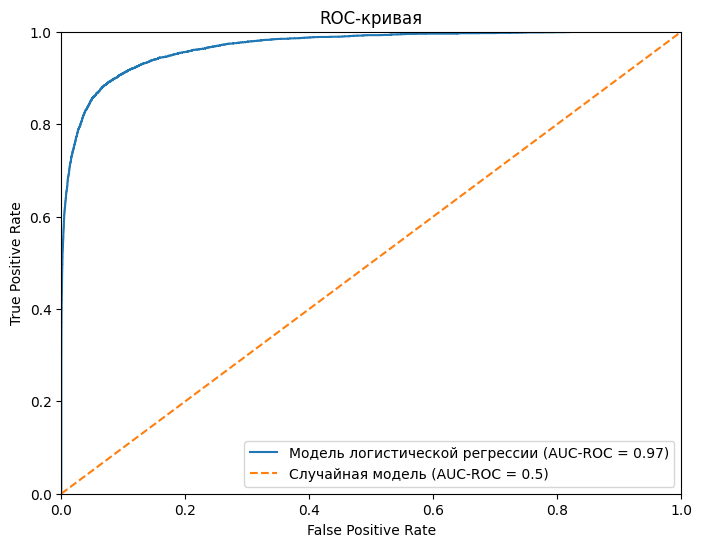

In [39]:
# значения FPR, TPR и рассмотренные пороги
fpr, tpr, thresholds = roc_curve(y_test, results['rs'][0].predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))

# построение графика ROC-кривой модели случайного леса
plt.plot(fpr, tpr, label='Модель логистической регрессии (AUC-ROC = %0.2f)' % auc_roc)
# построение графика ROC-кривой случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель (AUC-ROC = 0.5)')

# границы осей 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# подписи осей
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заголовок графика
plt.title('ROC-кривая')
# расположение легенды
plt.legend(loc='lower right');

### Вывод

Таким образом, модель `LogisticRegression` на тестовой выборке показала результат метрики качества ***F1-мера* = 0.76**. Значение ***AUC-ROC* = 0.97**, следовательно, модель адекватна, ее качество лучше, чем у случайной модели.

## Общий вывод

Было проведено исследование, позволившее построить модель для задачи классификации, которая прогнозирует эмоциональную окраску англоязычного текста. Модель поможет компании искать токсичные комментарии и отправлять их на модерацию. Входные данные - набор данных с разметкой о токсичности правок клиентов.

При изучении файла с данными не выявлено пропусков и дубликатов, обнаружен дисбаланс классов 9:1. Проведена очистка и лемматизация текстов в датасете.

Данные были разделены на обучающую и тестовую выборки в соотношении 3:1 с учетом дисбаланса классов в целевом признаке. Для определения тональности текстов были найдены величины TF-IDF для обучающего и тестового корпусов.

Были построены и обучены модели `LogisticRegression`, `LGBMClassifier` и `CatBoostClassifier` с помощью поиска по сетке гиперпараметров с учетом необходимости балансировки классов. В результате по критерию качества предсказания наилучшей оказалась модель **`LogisticRegression` с *F1-мера* = 0.76** (с взвешиванием классов).

Окончательная проверка качества модели `LogisticRegression` на тестовой выборке показала значение ***F1-мера* 0.76** и ***AUC-ROC* 0.97**.

Адекватность построенной модели подтвердилась путем сравнения значения метрики *AUC-ROC* со значением **0.5** для **случайной модели**.